In [21]:
"""
Follows https://www.tensorflow.org/tutorials/text/text_classification_rnn
"""
import pickle as pkl
import numpy as np
import random
import re

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

In [22]:
from datetime import datetime
datetime.now()

datetime.datetime(2020, 12, 21, 0, 7, 33, 2391)

In [23]:
def plot_graphs(history, metric):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(metric, color=color)
    ax1.plot(history.history[metric], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel("val_" + metric, color=color)  # we already handled the x-label with ax1
    ax2.plot(history.history["val_" + metric], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend([metric, "val_" + metric])

In [24]:
def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)

In [25]:
def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'

In [26]:
real_data = pkl.load(open("complete10000_films_and_synopsis.pickle", "rb"))
np.random.shuffle(real_data[500:])
data = real_data

In [27]:
# Fraction of overall data
training_fraction = 0.85

train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))


# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

In [28]:
sample, label = next(iter(train_dataset.take(1)))

In [29]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams=(1,2)
)


In [30]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [31]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[   3  221 1075 ...    0    0    0]
 [  63  848  387 ...    0    0    0]
 [   2    1 1159 ...    0    0    0]]


In [32]:
vocab = np.array(encoder.get_vocabulary())

for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b'The four members of the China Everest Climbing Commando confront the most difficult mount. The first four failures have cost them too much physical strength until the wind and snow stop the gap.'
Round-trip:  the four members of the china [UNK] climbing [UNK] confront the most difficult mount the first four [UNK] have cost them too much physical strength until the wind and snow stop the [UNK] the four [UNK] members of of the [UNK] [UNK] [UNK] [UNK] [UNK] confront the the most [UNK] [UNK] [UNK] the first [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] too much [UNK] [UNK] [UNK] until the [UNK] [UNK] [UNK] [UNK] stop the [UNK]                                                                                                                                                                                                                                                                                                        

Original:  b'Friends since childhood, a magazine editor and a hip-hop

In [33]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.1),
)

In [34]:
history = model.fit(
    train_dataset, epochs=100, validation_data=test_dataset, validation_steps=len(test_data_in) // BATCH_SIZE
)

Epoch 1/100
133/133 [==============================] - 51s 384ms/step - loss: 4016014538833920.0000 - val_loss: 888538472120320.0000
Epoch 2/100
133/133 [==============================] - 47s 352ms/step - loss: 3627779023175680.0000 - val_loss: 915872919060480.0000
Epoch 3/100
133/133 [==============================] - 47s 353ms/step - loss: 3582606436204544.0000 - val_loss: 901379015049216.0000
Epoch 4/100
133/133 [==============================] - 46s 350ms/step - loss: 3543307753881600.0000 - val_loss: 937185956069376.0000
Epoch 5/100
133/133 [==============================] - 48s 360ms/step - loss: 3513780927463424.0000 - val_loss: 1045659113226240.0000
Epoch 6/100
133/133 [==============================] - 47s 357ms/step - loss: 3482355725500416.0000 - val_loss: 962425264275456.0000
Epoch 7/100
133/133 [==============================] - 48s 360ms/step - loss: 3491176783020032.0000 - val_loss: 960176916004864.0000
Epoch 8/100
133/133 [==============================] - 46s 342ms/ste

In [35]:
res = model.evaluate(test_dataset)

24/24 [==============================] - 3s 106ms/step - loss: 1583728522428416.0000


In [36]:
sample_text = "As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace."
pred1 = model.predict(np.array([sample_text]))
print(int(pred1[0]))

39408544


In [37]:
non_existant_film = "Este is a friend of mine we meet up every tuesday night for dinner and a glass of wine. She thinks he did it but just cant prove it"
pred2 = model.predict(np.array([non_existant_film]))
print(int(pred2[0]))

8087432


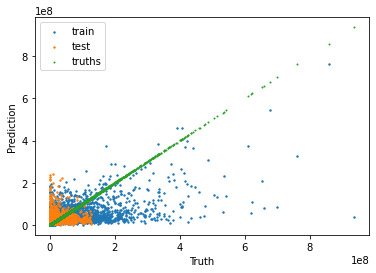

<Figure size 432x288 with 0 Axes>

In [38]:
test_predictions = model.predict(test_data_in)
train_predictions = model.predict(train_data_in)
plt.scatter(train_data_out, train_predictions, label='train', s=2)
plt.scatter(test_data_out, test_predictions, label='test', s=2)
plt.scatter(real_data['gross'], real_data['gross'], label='truths', s=1)
plt.legend()
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()
plt.savefig("exp_15.pdf", dpi=300)

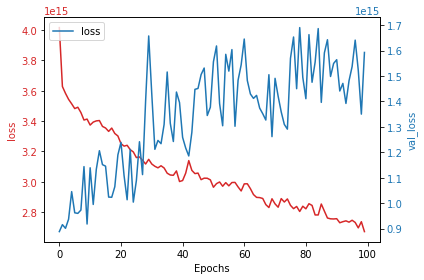

In [39]:
plot_graphs(history,'loss')
plt.savefig("exp_15_2.pdf", dpi=300)

In [40]:
import pickle as pkl
pkl.dump(history, open('exp_15.pkl','wb'))

TypeError: cannot pickle '_thread.RLock' object